# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [112]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as rmse


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:
sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
print(sensor.isna().sum())
print(sensor.isnull().sum())


attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64


How many rows and columns are in our data?

In [5]:
sensor.shape
# There are 1751 rows and 12 columns

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [6]:
sec = pd.date_range(start='2018-01-01 00:00:00', end='2018-01-01 00:29:10', freq= 'S')
# print(len(sec))

Assign the time series index to the dataframe's index.

In [7]:
# Your code here:
sensor.index = list(sec)
sensor.head(5)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

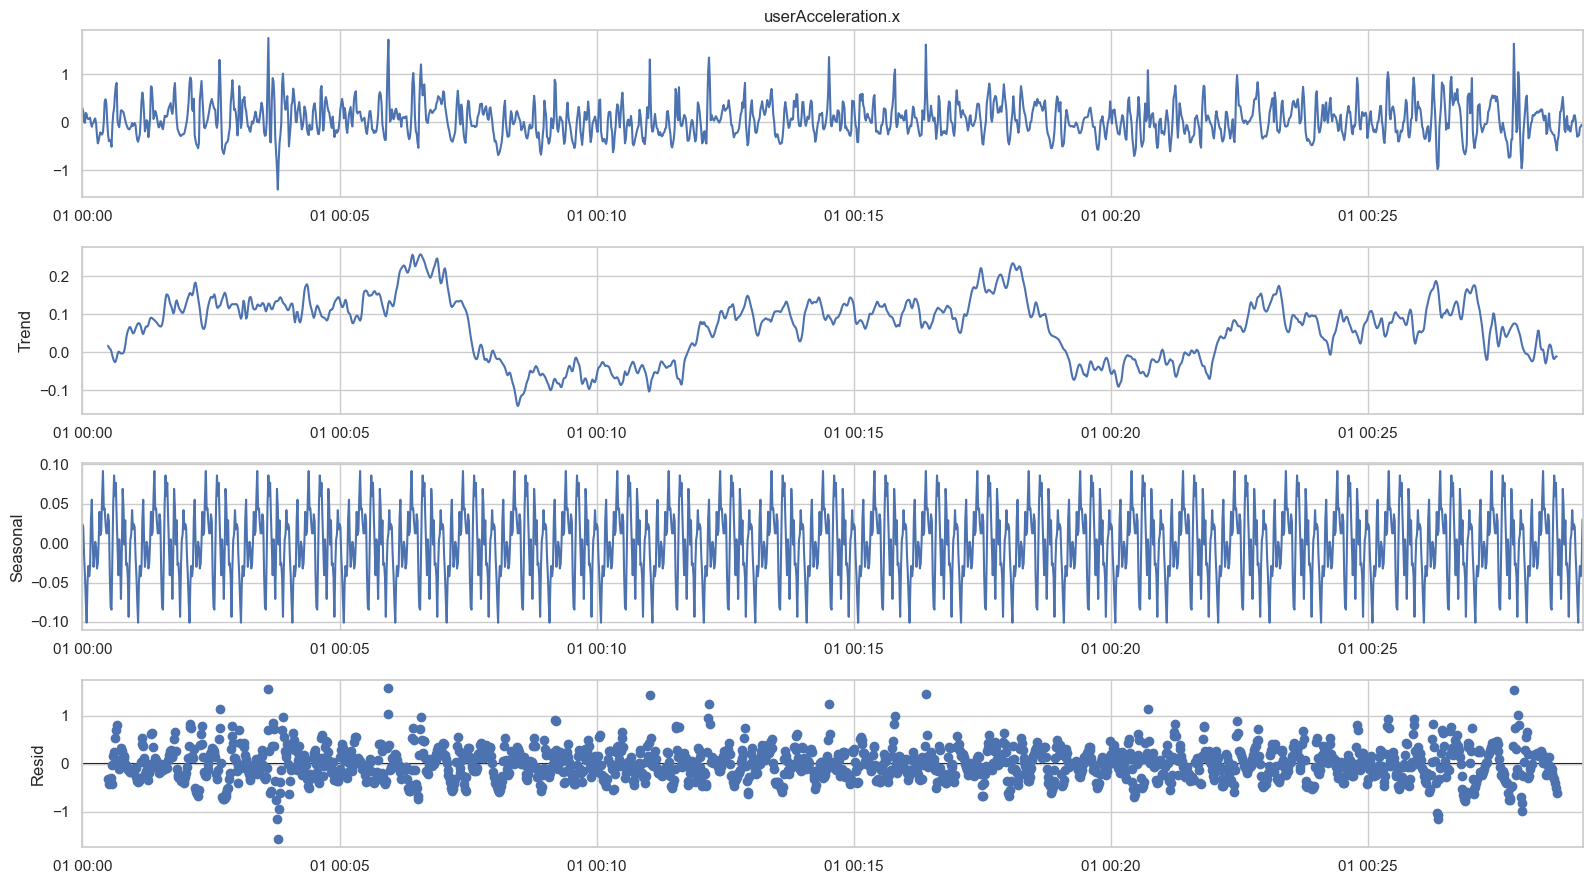

In [21]:

res = seasonal_decompose(sensor["userAcceleration.x"], model="additive", period= 60)
res.plot();



Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

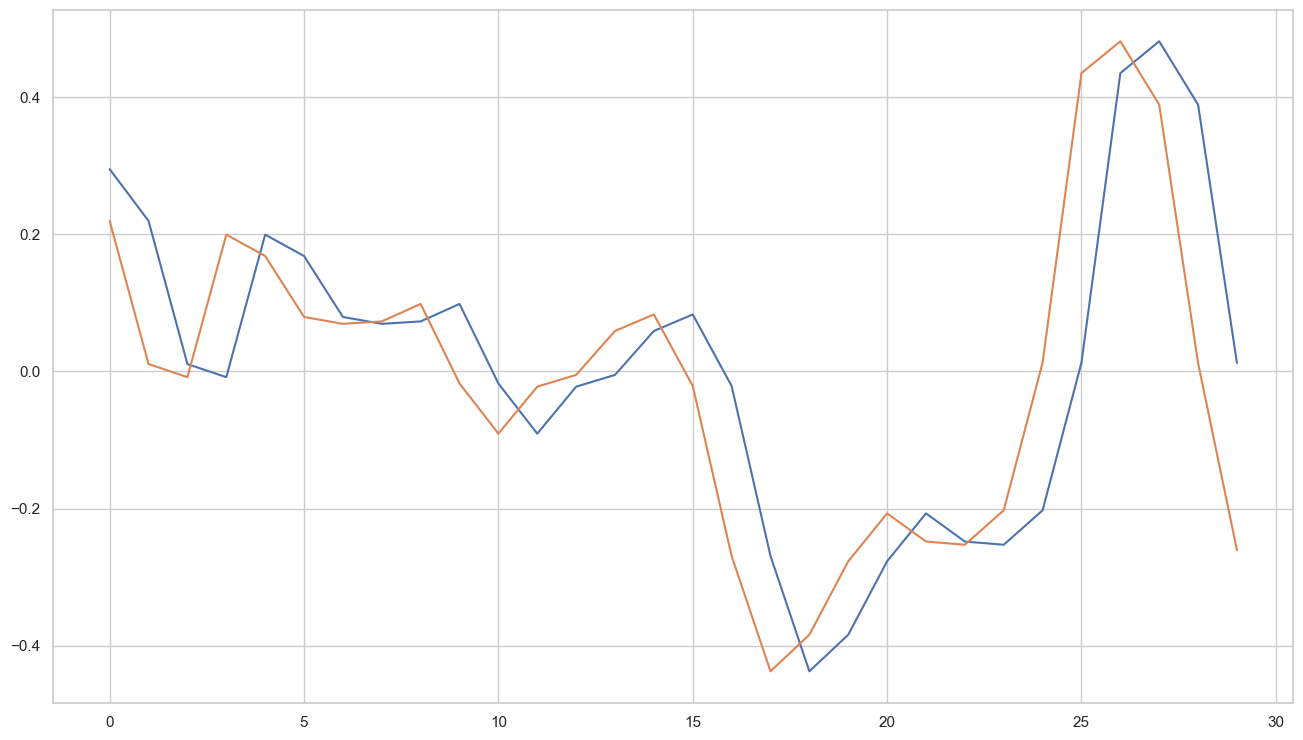

In [25]:
# Your code here:
data = sensor["userAcceleration.x"][:-1]
data_lagged = sensor["userAcceleration.x"][1:]
plt.plot(data.values[:30])
plt.plot(data_lagged.values[:30]);

Create a lag plot for `rotationRate.x`

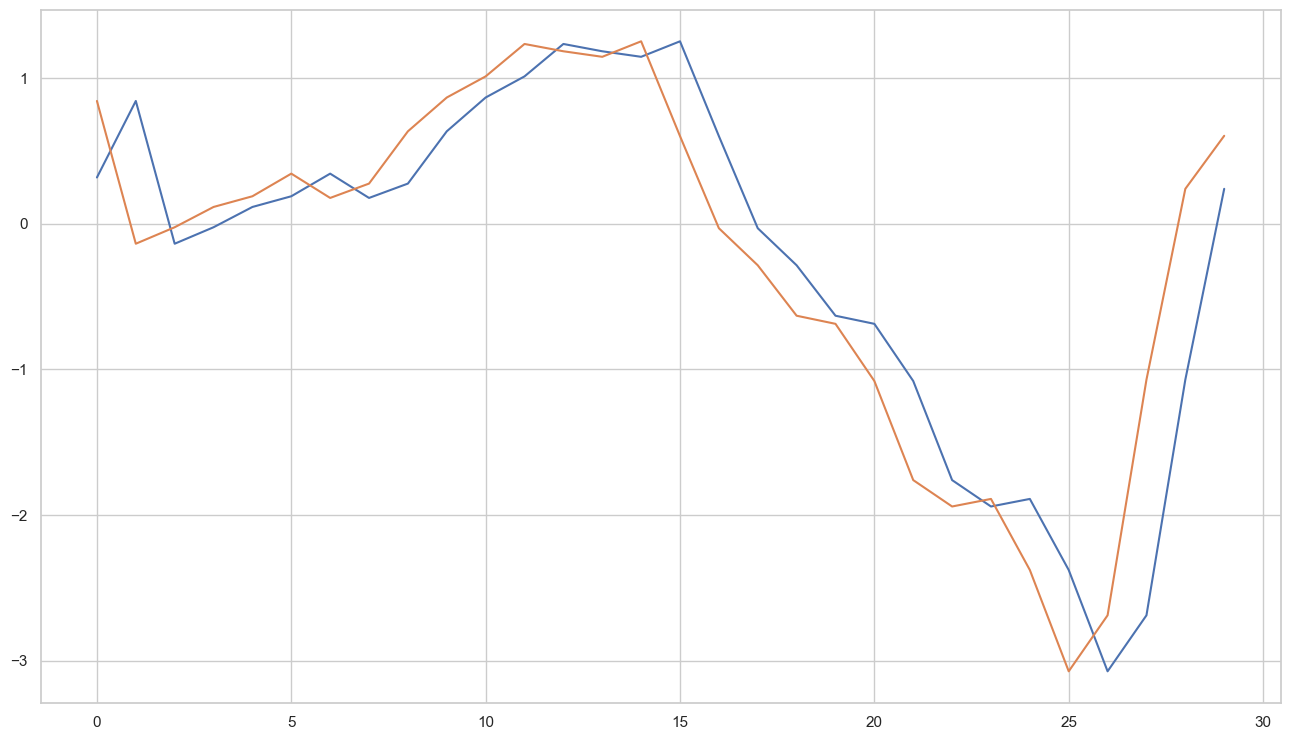

In [32]:
# Your code here:
data = sensor["rotationRate.x"][:-1]
data_lagged = sensor["rotationRate.x"][1:]
plt.plot(data.values[:30])
plt.plot(data_lagged.values[:30]);

# plot_acf(sensor["rotationRate.x"], alpha=0.2);

What are your conclusions from both visualizations?

In [11]:
# They are correlated?


The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [38]:
test_1 = adfuller(sensor["rotationRate.x"])
print(f"This is the result of test1: {test_1}")


test_2 = adfuller(sensor["userAcceleration.x"])
print(f"\nThis is the result of test2: {test_2}")

This is the result of test1: (-5.269860625086421, 6.320230335912189e-06, 25, 1725, {'1%': -3.4341465551936534, '5%': -2.863216966926812, '10%': -2.567662770090317}, 2619.6049719981947)

This is the result of test2: (-17.95799408616974, 2.823439483037563e-30, 4, 1746, {'1%': -3.434100824760071, '5%': -2.863196780129223, '10%': -2.5676520210882936}, -727.6140124402791)


What are your conclusions from this test?

In [13]:
# We can reject the null hypothesis, as pvalue is below 0,05. According it is stationary.



## Bonus: Challenge 2

Finally, we'll create an ARIMA model for `userAcceleration.x`. Load the `ARIMA` function from `statsmodels`. The order of the model is (2, 0, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [39]:
order = (2, 0, 1)

In [191]:
# 0. Splitting into train & test
y_train = sensor["userAcceleration.x"][:-10]
y_test = sensor["userAcceleration.x"][-11:]

In [192]:
# 1. Create an instance of the ARIMA model that takes y_train, the order, and freq="S"
# Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html
arima = ARIMA(y_train, order = (2, 0, 1), freq="S")

C:\Users\gnsg3\anaconda3\envs\Ironhack\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)


In [193]:
# 2. Fit the model:
model = arima.fit()

In [194]:
# 3. Predict: create y_pred:
sensor["y_pred"] = model.predict(start=len(y_train)-20, end=len(sensor))

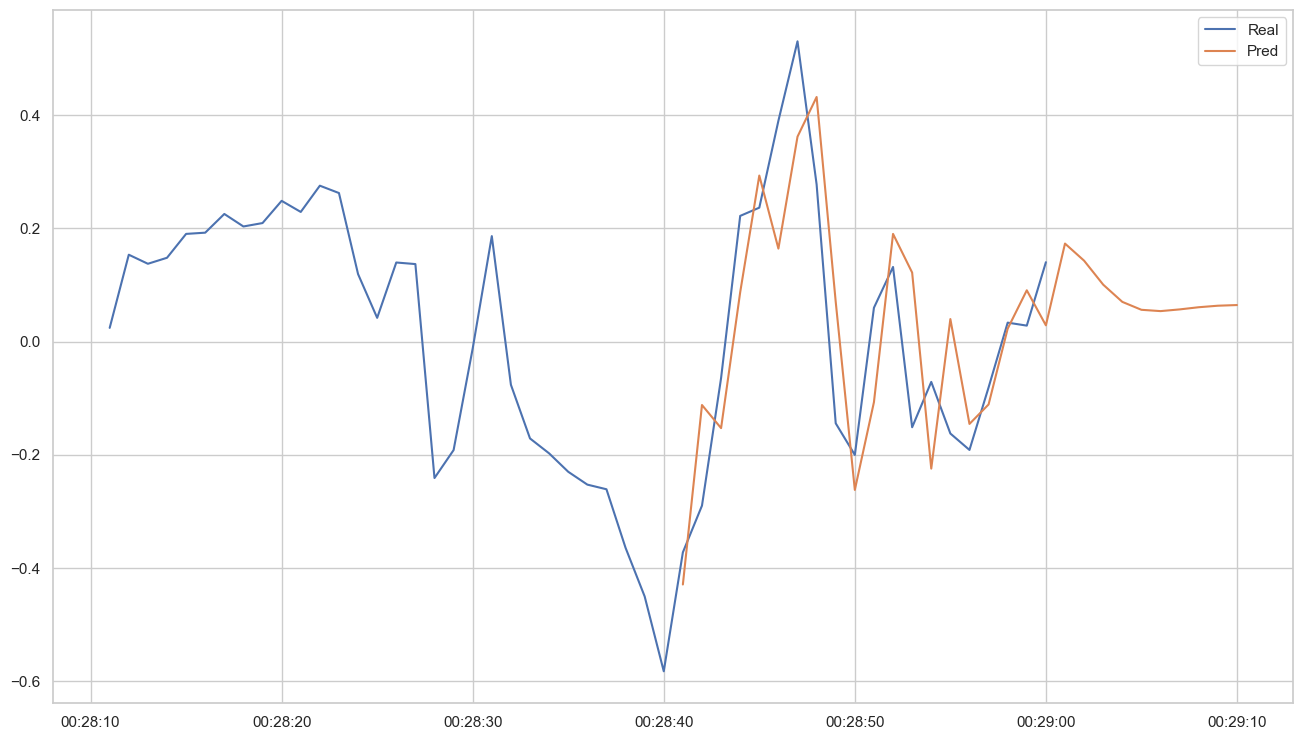

In [195]:
# 4. Visualize
plt.plot(y_train[-50:], label = "Real")
plt.plot(sensor["y_pred"], label = "Pred")
plt.legend()

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [196]:
# Your code here:
# rmse = np.sqrt(mean_squared_error(sensor["y_pred"], y_test))
rmse(sensor["y_pred"][-11:], y_test)

0.047273724369418325